In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

import geopandas as gpd

In [2]:
# Cleaning Data

dataset = pd.read_csv("SuperstoreDataset.csv")
dataset = dataset.drop(columns=["Customer Name","Country","Postal Code","Unnamed: 17"]).sort_values(["Region","State","City"],ascending=[True,True,True])[["Region","State","City","Customer ID","Segment","Product ID","Product Name","Ship Mode","Category","Sub-Category","Sales","Quantity","Discount","Profit"]].reset_index().drop(columns=["index"])
dataset

,Region,State,City,Customer ID,Segment,Product ID,Product Name,Ship Mode,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Central,Illinois,Arlington Heights,SC-20845,Consumer,OFF-AR-10003394,Newell 332,Standard Class,Office Supplies,Art,14.112,6,0.2,1.2348
1,Central,Illinois,Aurora,EH-14125,Home Office,FUR-CH-10001215,Global Troy Executive Leather Low-Back Tilter,Same Day,Furniture,Chairs,701.372,2,0.3,-50.0980
2,Central,Illinois,Aurora,EH-14125,Home Office,OFF-BI-10004654,Avery Binding System Hidden Tab Executive Styl...,Same Day,Office Supplies,Binders,2.308,2,0.8,-3.4620
3,Central,Illinois,Aurora,JK-16120,Home Office,FUR-FU-10003394,"Tenex ""The Solids"" Textured Chair Mats",Standard Class,Furniture,Furnishings,83.952,3,0.6,-90.2484
4,Central,Illinois,Aurora,CK-12760,Corporate,FUR-TA-10002958,"Bevis Oval Conference Table, Walnut",Standard Class,Furniture,Tables,652.450,5,0.5,-430.6170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,West,Washington,Vancouver,AR-10825,Corporate,TEC-PH-10003273,AT&T TR1909W,Second Class,Technology,Phones,302.376,3,0.2,22.6782
9990,West,Washington,Vancouver,AR-10825,Corporate,TEC-AC-10001142,First Data FD10 PIN Pad,Second Class,Technology,Accessories,316.000,4,0.0,31.6000
9991,West,Washington,Vancouver,FM-14290,Home Office,OFF-AR-10002956,Boston 16801 Nautilus Battery Pencil Sharpener,Standard Class,Office Supplies,Art,44.020,2,0.0,11.4452
9992,West,Washington,Vancouver,JW-15220,Corporate,FUR-FU-10002885,Magna Visual Magnetic Picture Hangers,Standard Class,Furniture,Furnishings,9.640,2,0.0,3.6632


In [3]:
# Separating States by Regions and Creating Spatial File for Visualization

regions = ["Central","West","East","South"]
region_data = {}

gdf = gpd.read_file("us_states")
gdf = gdf.rename(columns={"NAME":"state"})
gdf_dict = {}

for region in regions:    
    region_data[region] = dataset[dataset["Region"] == region]
    region_data[region].sort_values(by="State")
    set_region = set(region_data[region]["State"].unique())
    gdf_dict[region] = gdf.loc[gdf["state"].isin(set_region)].reset_index().drop(columns=["GEO_ID","STATE","index","CENSUSAREA","LSAD"])
    region_data[region] = pd.DataFrame(region_data[region].groupby("State").sum()).reset_index()
    region_data[region] = pd.concat([region_data[region],gdf_dict[region]],axis = 1) 
    region_data[region] = region_data[region].sort_values(by="Profit",ascending=False).reset_index().drop(columns = ["Quantity","Discount","index","state"])

region_gdf = pd.concat([region_data["Central"],region_data["East"],region_data["West"],region_data["South"]]) 
region_gdf = gpd.GeoDataFrame(region_gdf, geometry='geometry')
region_gdf.to_file("states.geojson", driver="GeoJSON")

for region in regions:
    region_data[region].drop(columns=["geometry"],inplace = True)
    region_data[region].to_csv("region_data/{}_region_data.csv".format(region.lower()),index=False)

In [4]:
region_data["Central"]

,State,Sales,Profit
0,Michigan,76269.6140,24463.1876
1,Indiana,53555.3600,18382.9363
2,Minnesota,29863.1500,10823.1874
3,Wisconsin,32114.6100,8401.8004
4,Missouri,22205.1500,6436.2105
5,Oklahoma,19683.3900,4853.9560
6,Nebraska,7464.9300,2037.0942
7,Iowa,4579.7600,1183.8119
8,Kansas,2914.3100,836.4435
9,South Dakota,1315.5600,394.8283


In [9]:
region_data["East"]

,State,Sales,Profit
0,New York,310876.271,74038.5486
1,Delaware,27451.069,9977.3748
2,New Jersey,35764.312,9772.9138
3,Rhode Island,22627.956,7285.6293
4,Maryland,23705.523,7031.1788
5,Massachusetts,28634.434,6785.5016
6,Connecticut,13384.357,3511.4918
7,Vermont,8929.370,2244.9783
8,New Hampshire,7292.524,1706.5028
9,District of Columbia,2865.020,1059.5893


In [8]:
region_data["South"]

,State,Sales,Profit
0,Virginia,70636.720,18597.9504
1,Georgia,49095.840,16250.0433
2,Kentucky,36591.750,11199.6966
3,Alabama,19510.640,5786.8253
4,Arkansas,11678.130,4008.6871
5,Mississippi,10771.340,3172.9762
6,Louisiana,9217.030,2196.1023
7,South Carolina,8481.710,1769.0566
8,Florida,89473.708,-3399.3017
9,Tennessee,30661.873,-5341.6936


In [7]:
region_data["West"]

,State,Sales,Profit
0,California,457687.6315,76381.3871
1,Washington,138641.2700,33402.6517
2,Nevada,16729.1020,3316.7659
3,Utah,11220.0560,2546.5335
4,Montana,5589.3520,1833.3285
5,New Mexico,4783.5220,1157.1161
6,Idaho,4382.4860,826.7231
7,Wyoming,1603.1360,100.1960
8,Oregon,17431.1500,-1190.4705
9,Arizona,35282.0010,-3427.9246


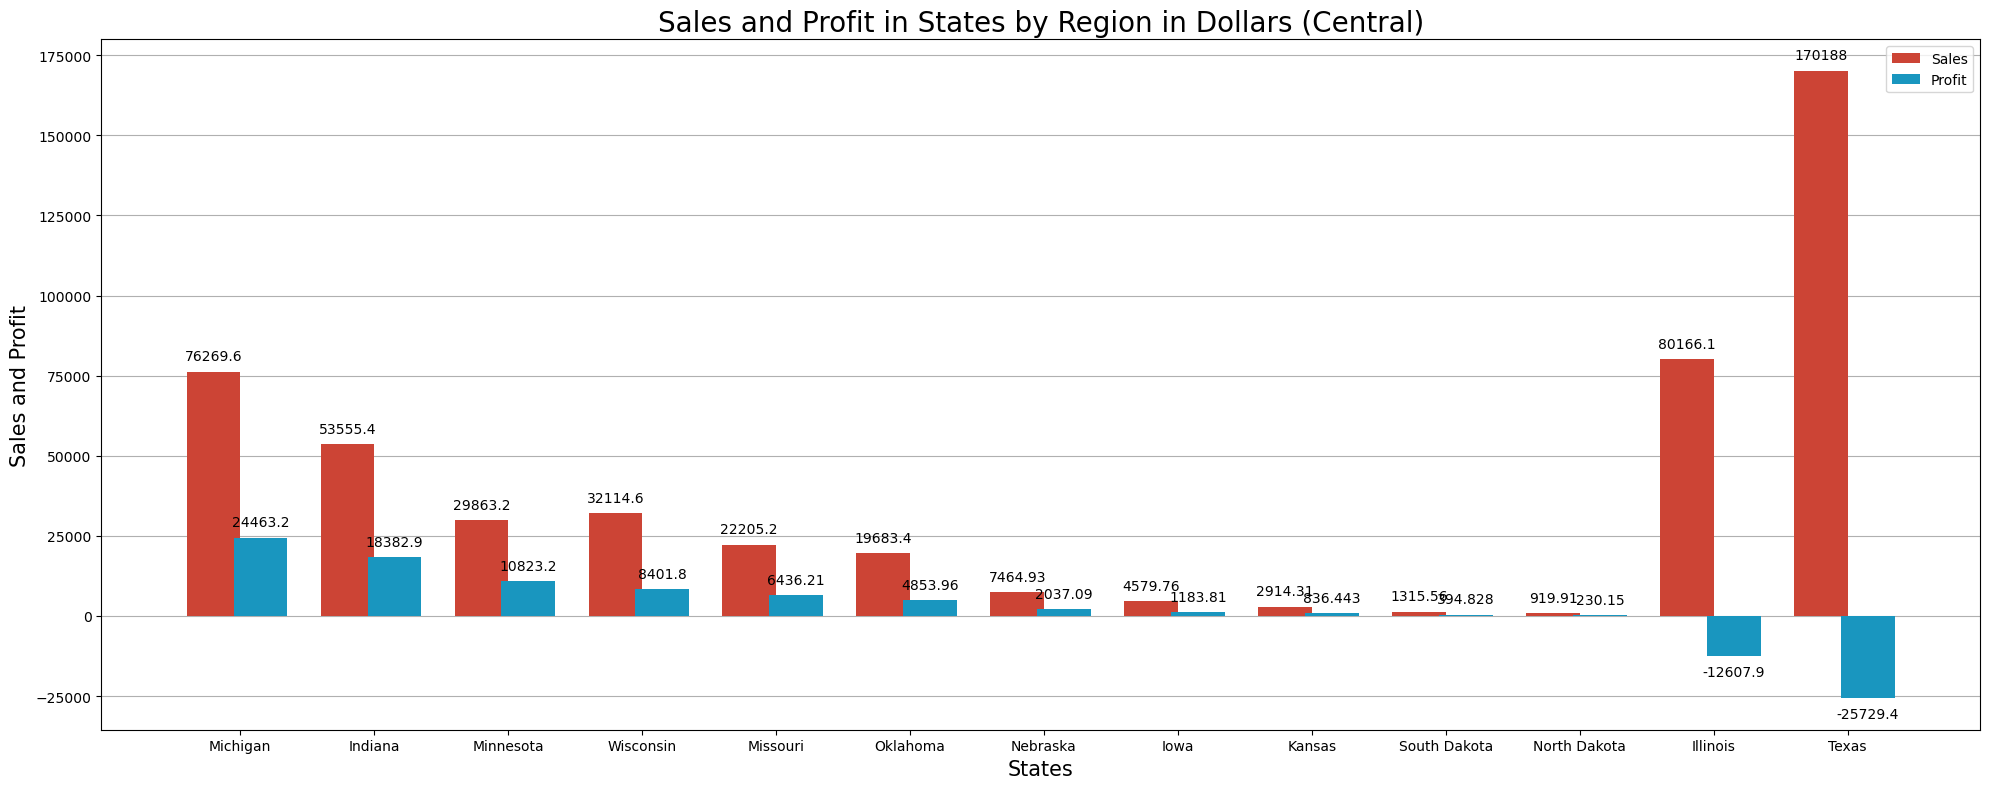

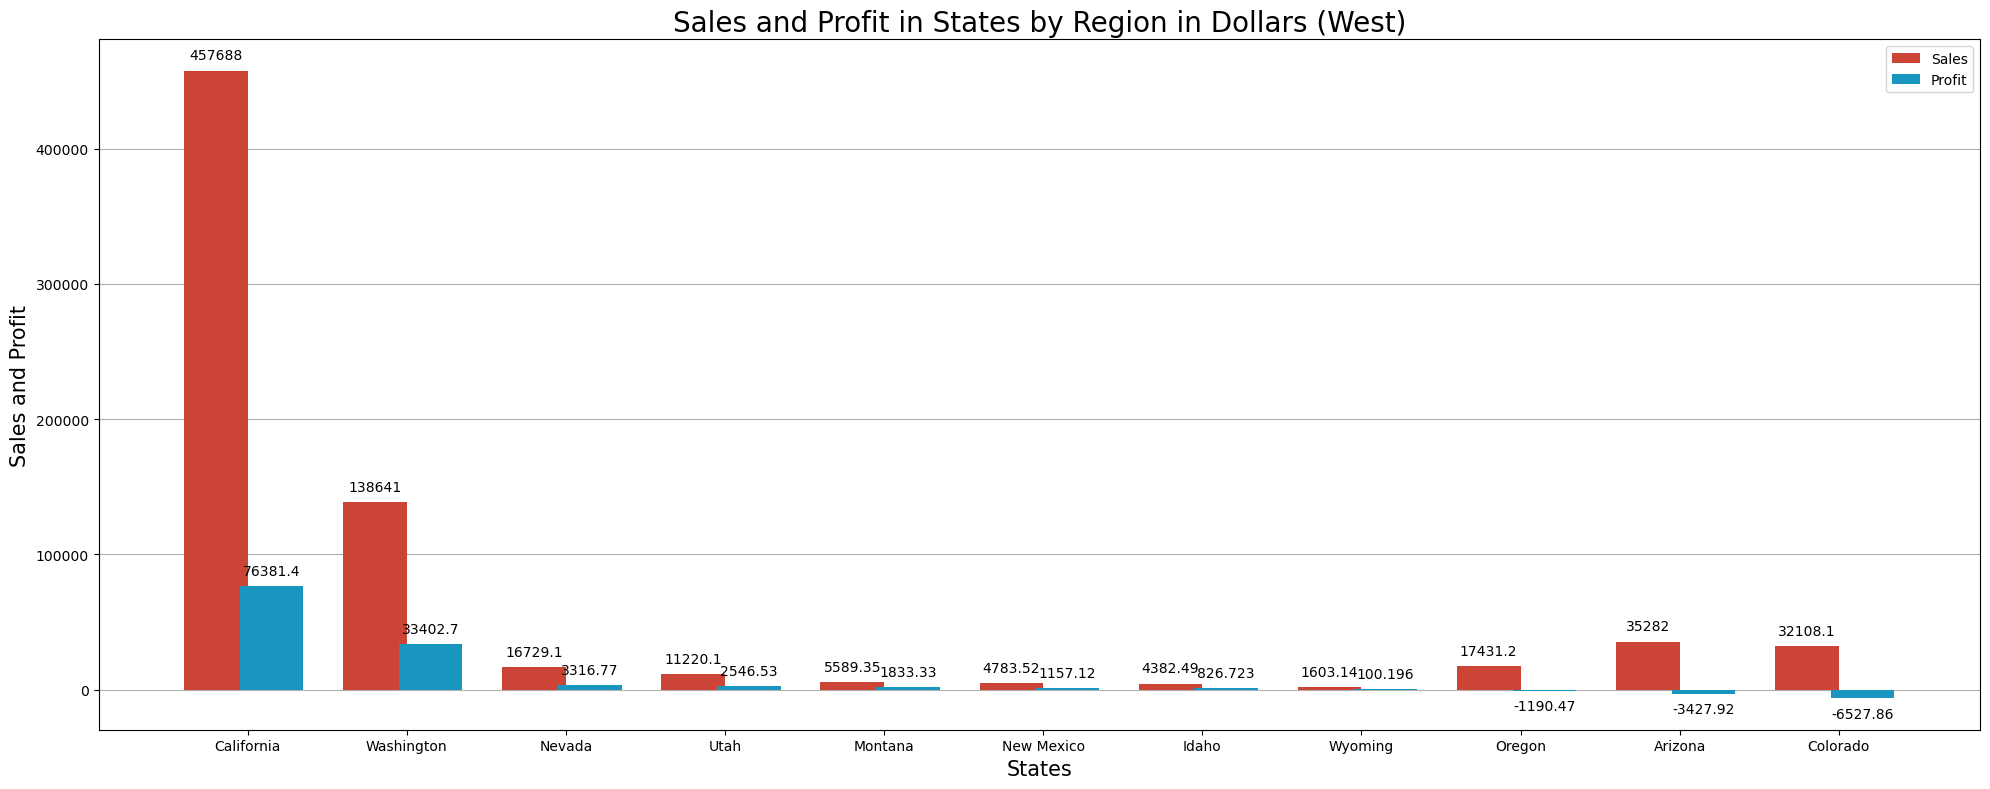

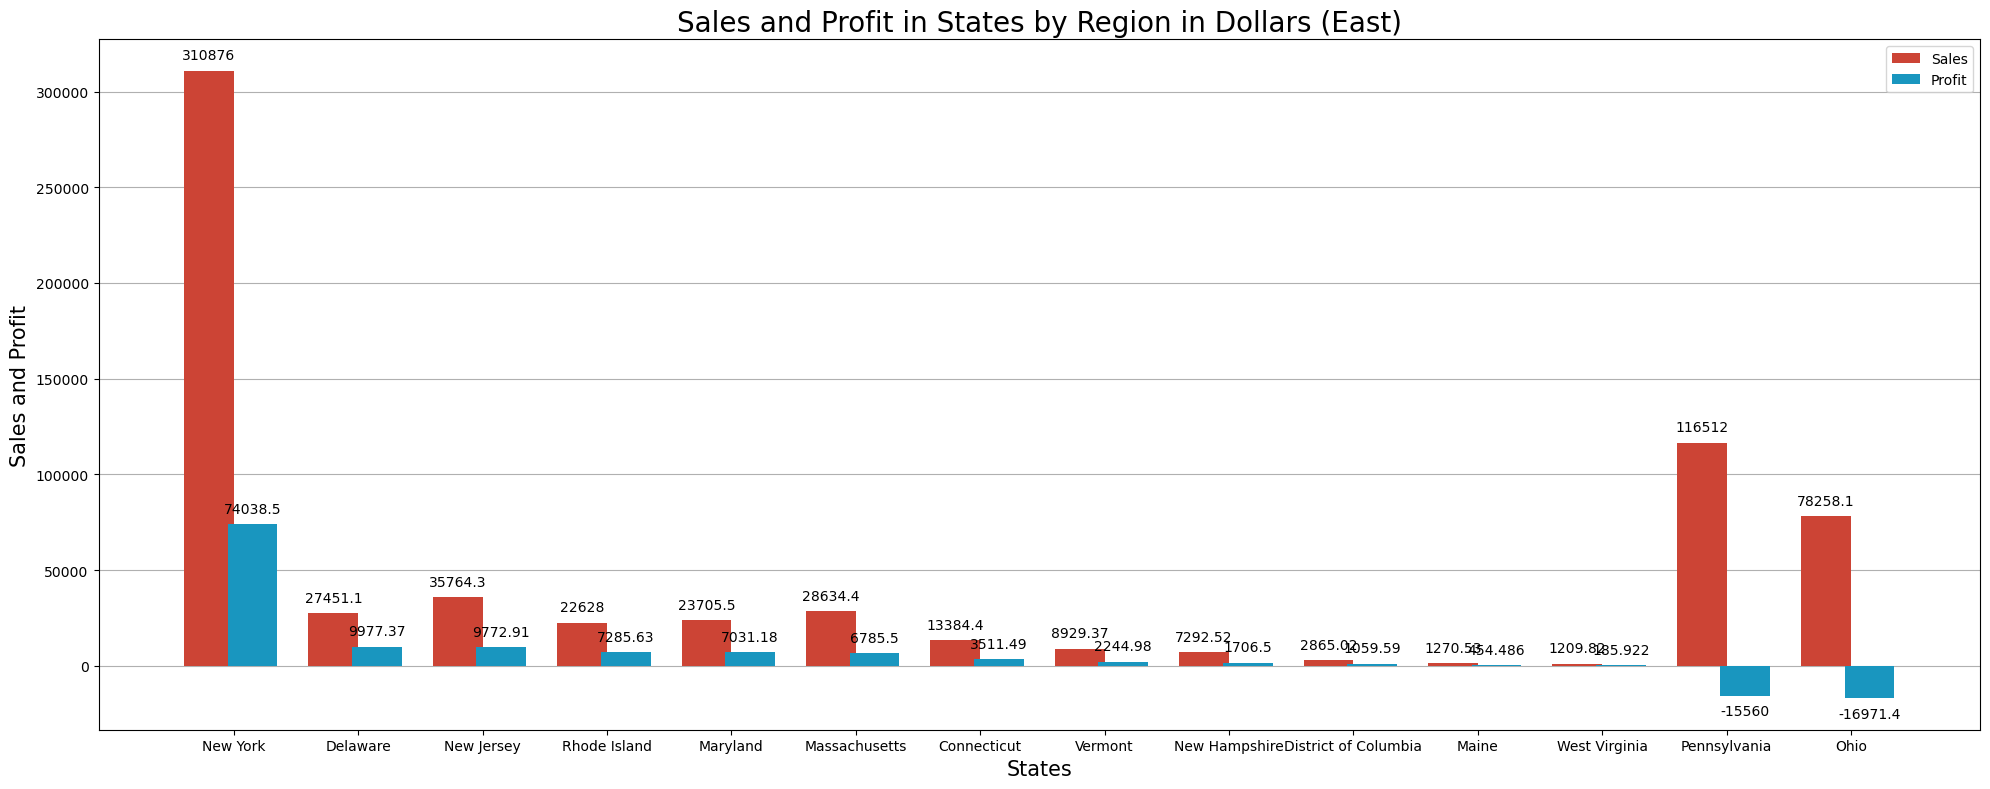

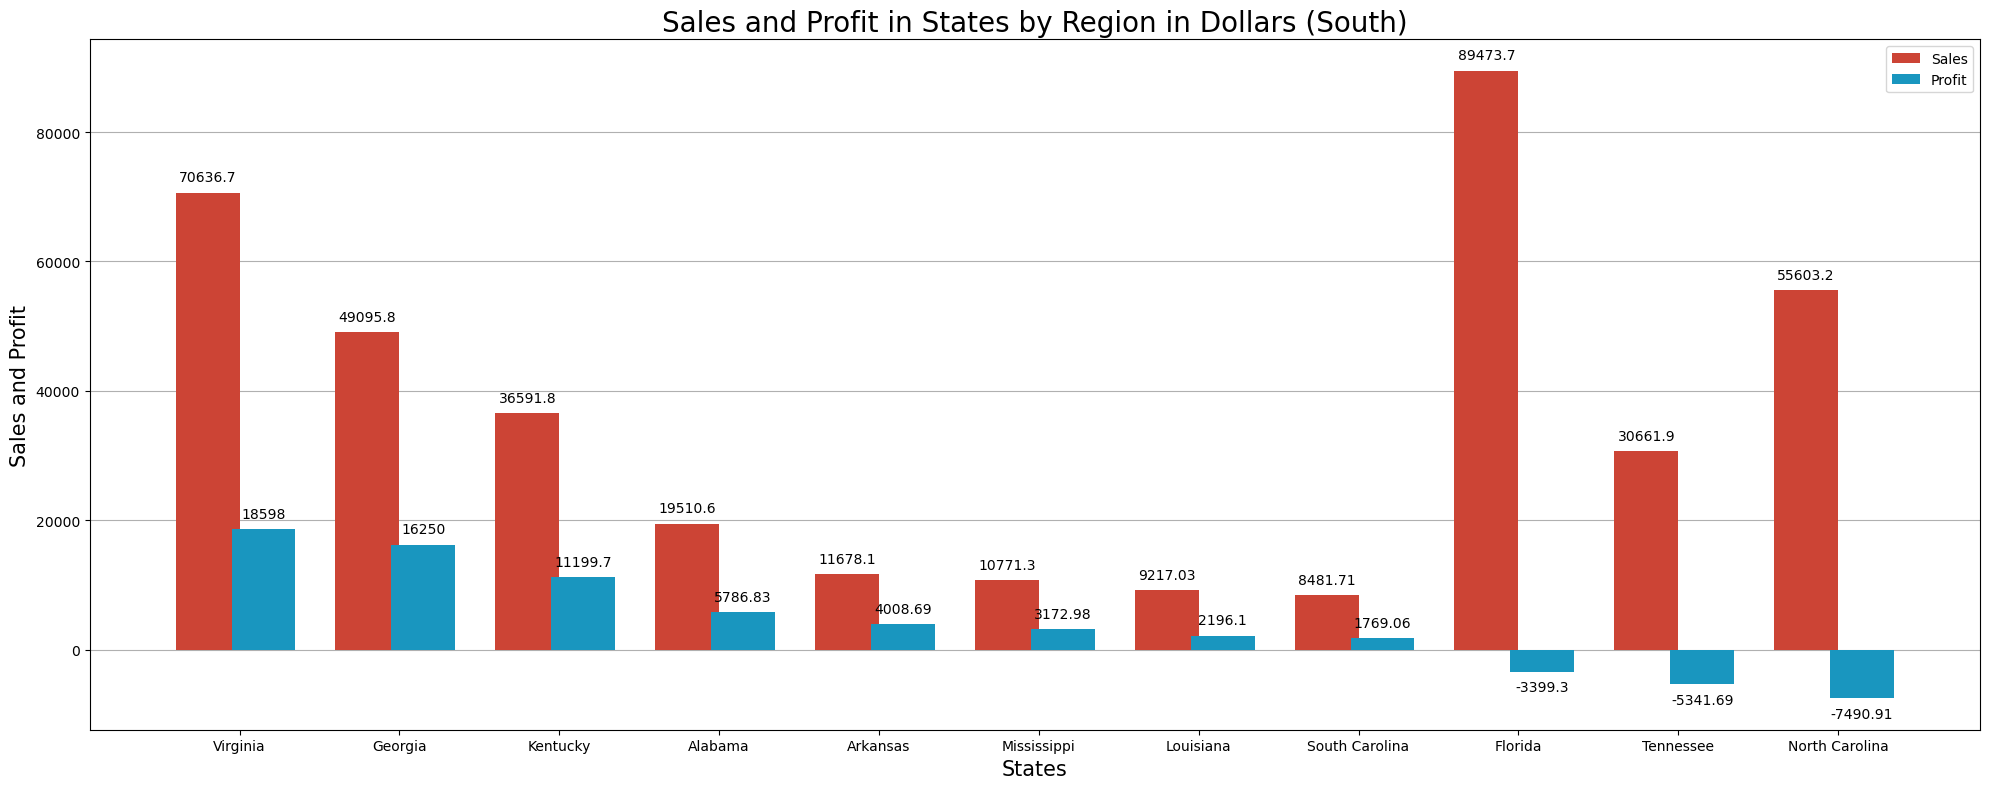

In [10]:
# Charts for Profit and Sales in States by Region

for region_df in regions:
    x = list(region_data[region_df]["State"])
    x_labels = np.arange(len(x))
    y1 = np.array(region_data[region_df]["Sales"])
    y2 = np.array(region_data[region_df]["Profit"])

    fig, ax = plt.subplots(figsize=(20,8),dpi=100)
    sales_bar = ax.bar(x_labels - 0.2, y1, 0.4, label = 'Sales',color = "#cc4435",zorder = 3)
    profit_bar = ax.bar(x_labels + 0.15, y2, 0.4, label = 'Profit', color = "#1996bf", zorder = 3)

    ax.set_ylabel("Sales and Profit",fontsize = 15)
    ax.set_xlabel("States",fontsize = 15)
    ax.set_title("Sales and Profit in States by Region in Dollars ({})".format(region_df),fontsize = 20)
    ax.set_xticks(x_labels)
    ax.set_xticklabels(x)
    ax.legend()
    ax.bar_label(sales_bar, padding=6)
    ax.bar_label(profit_bar, padding=6)
    ax.grid(axis = 'y',zorder = 0)
    fig.tight_layout()
    fig.savefig("sales_profit_charts/{}_sales_profit_chart.png".format(region_df.lower()))

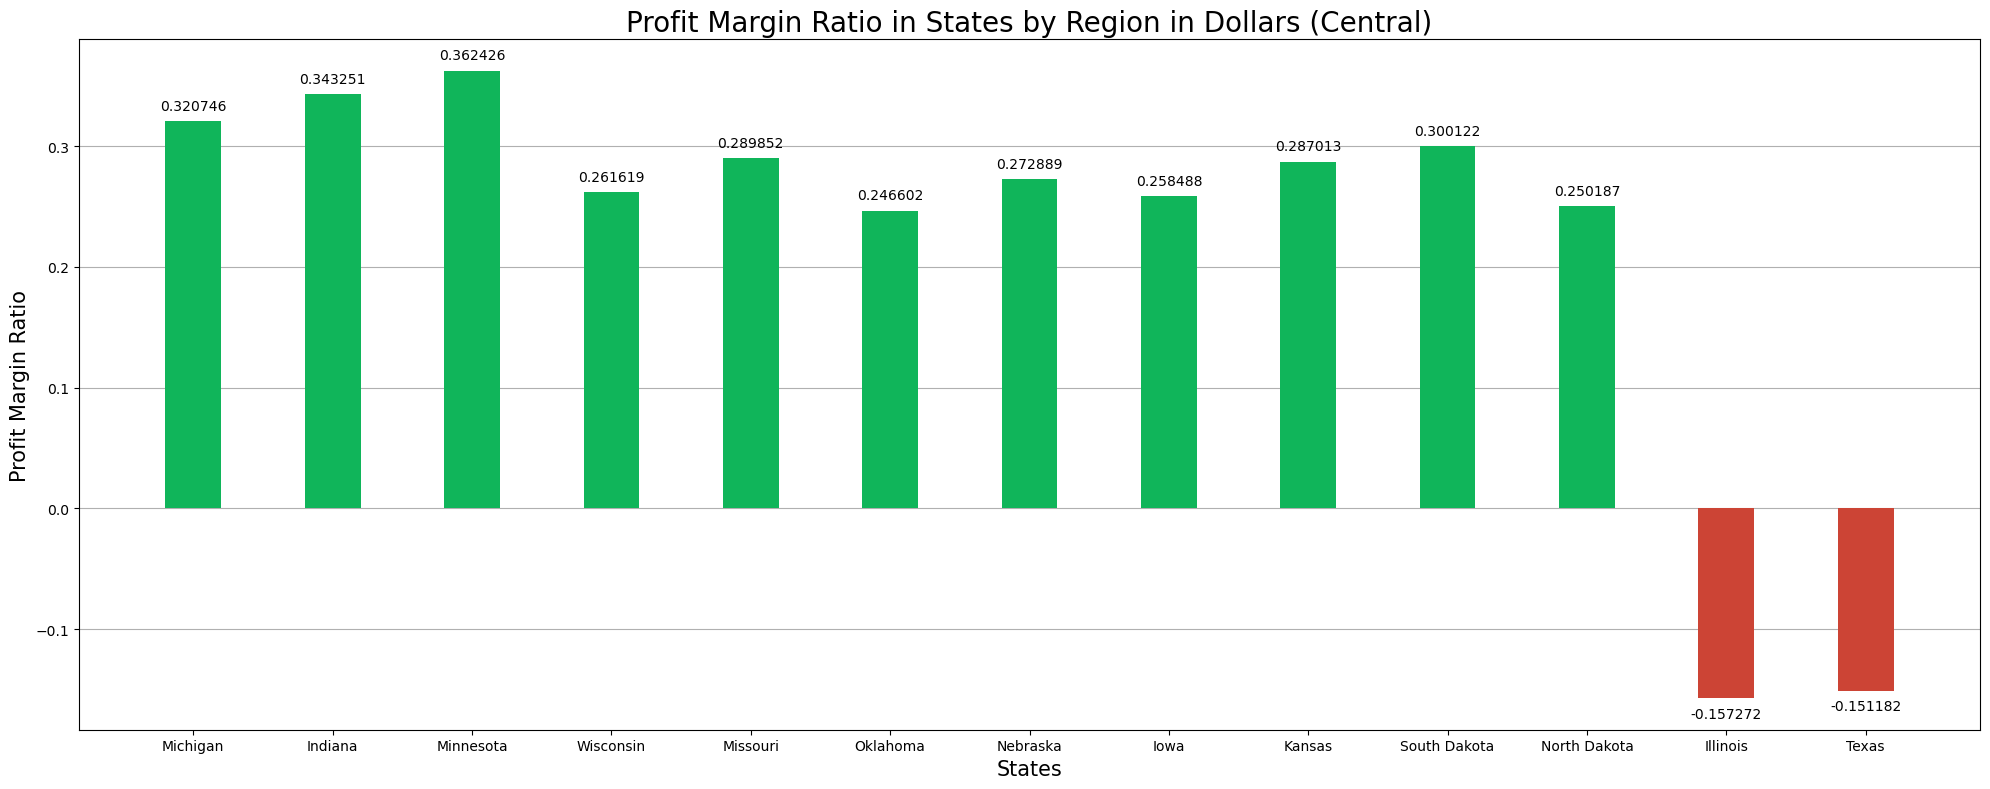

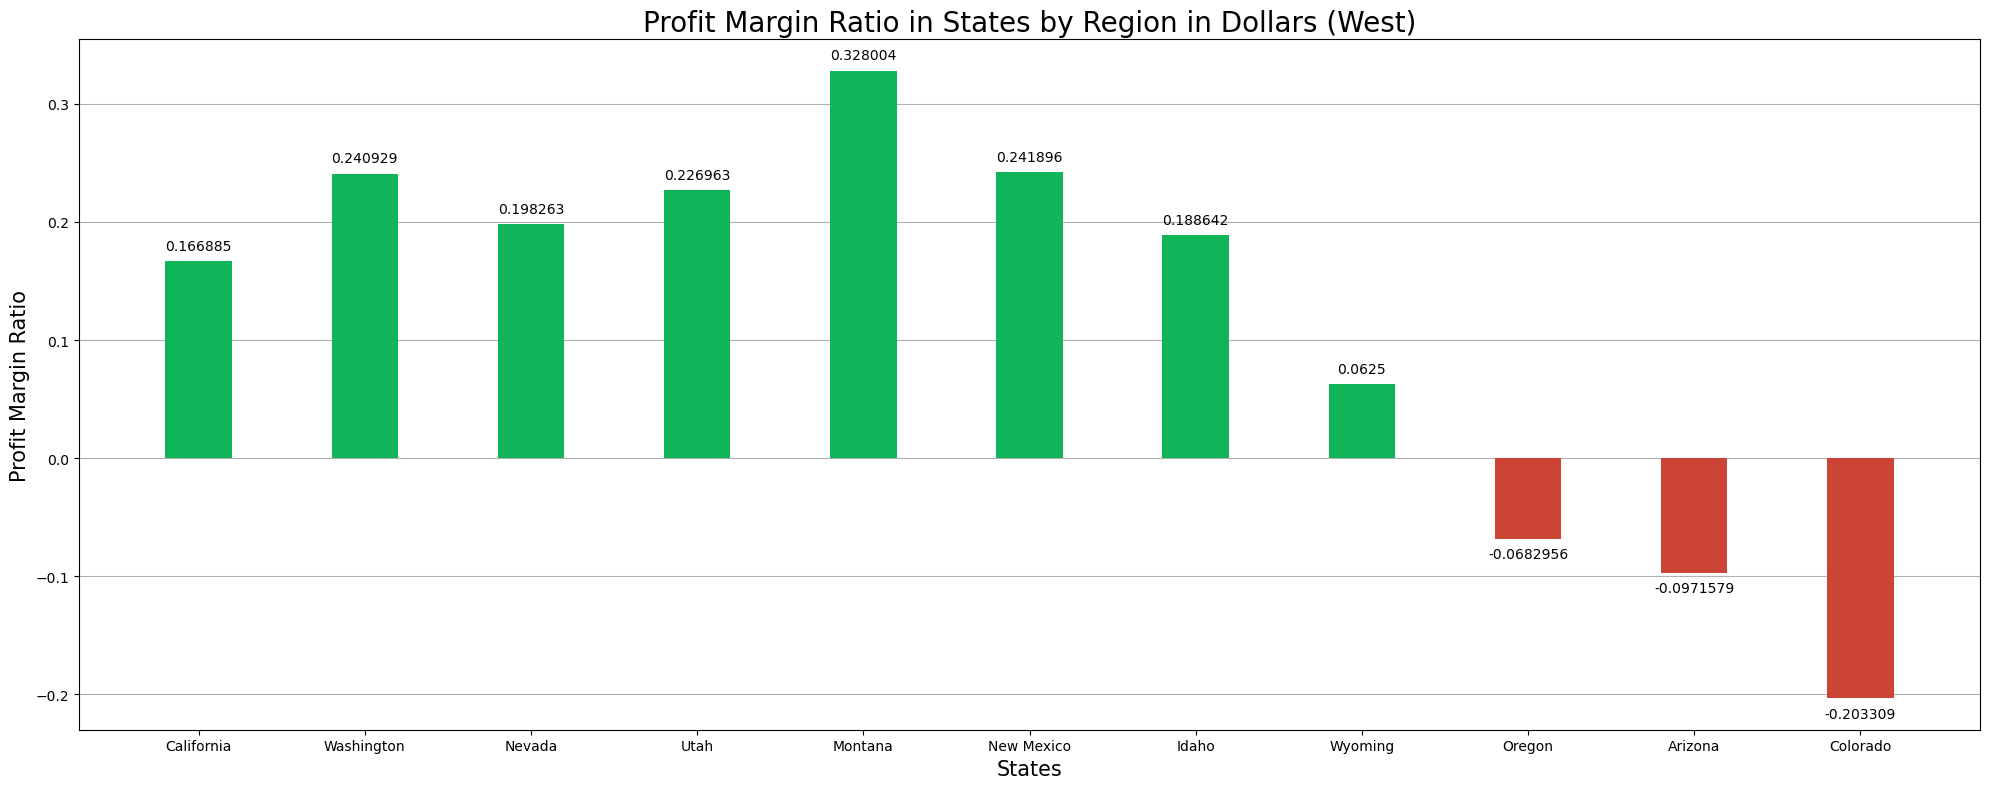

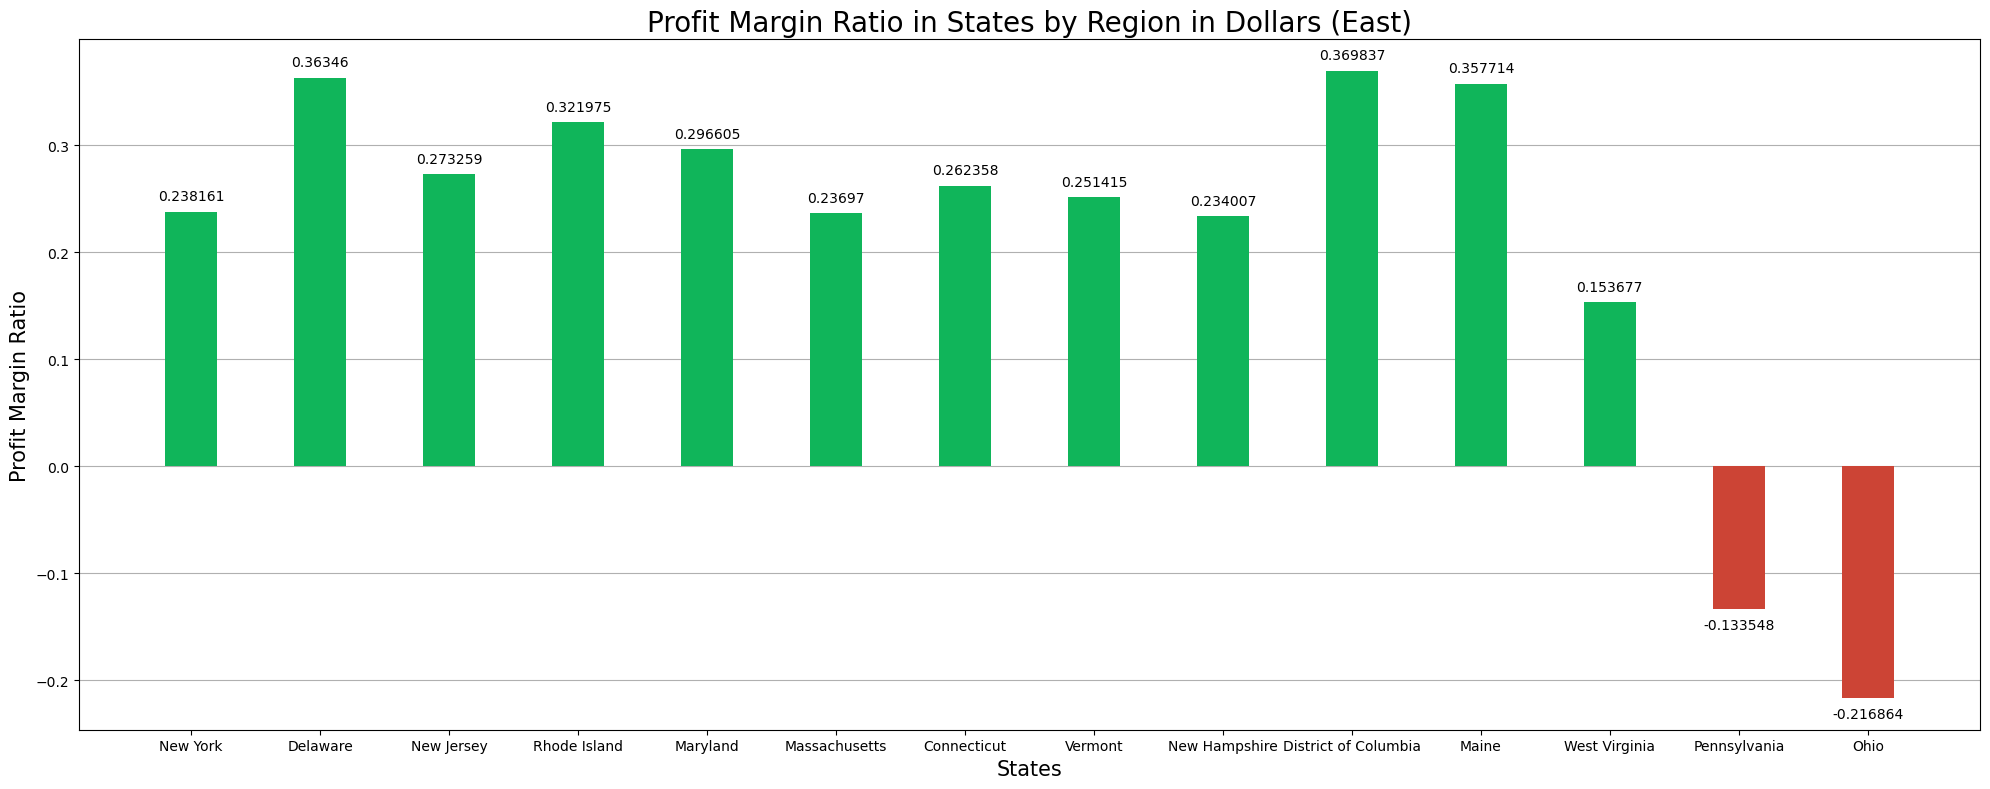

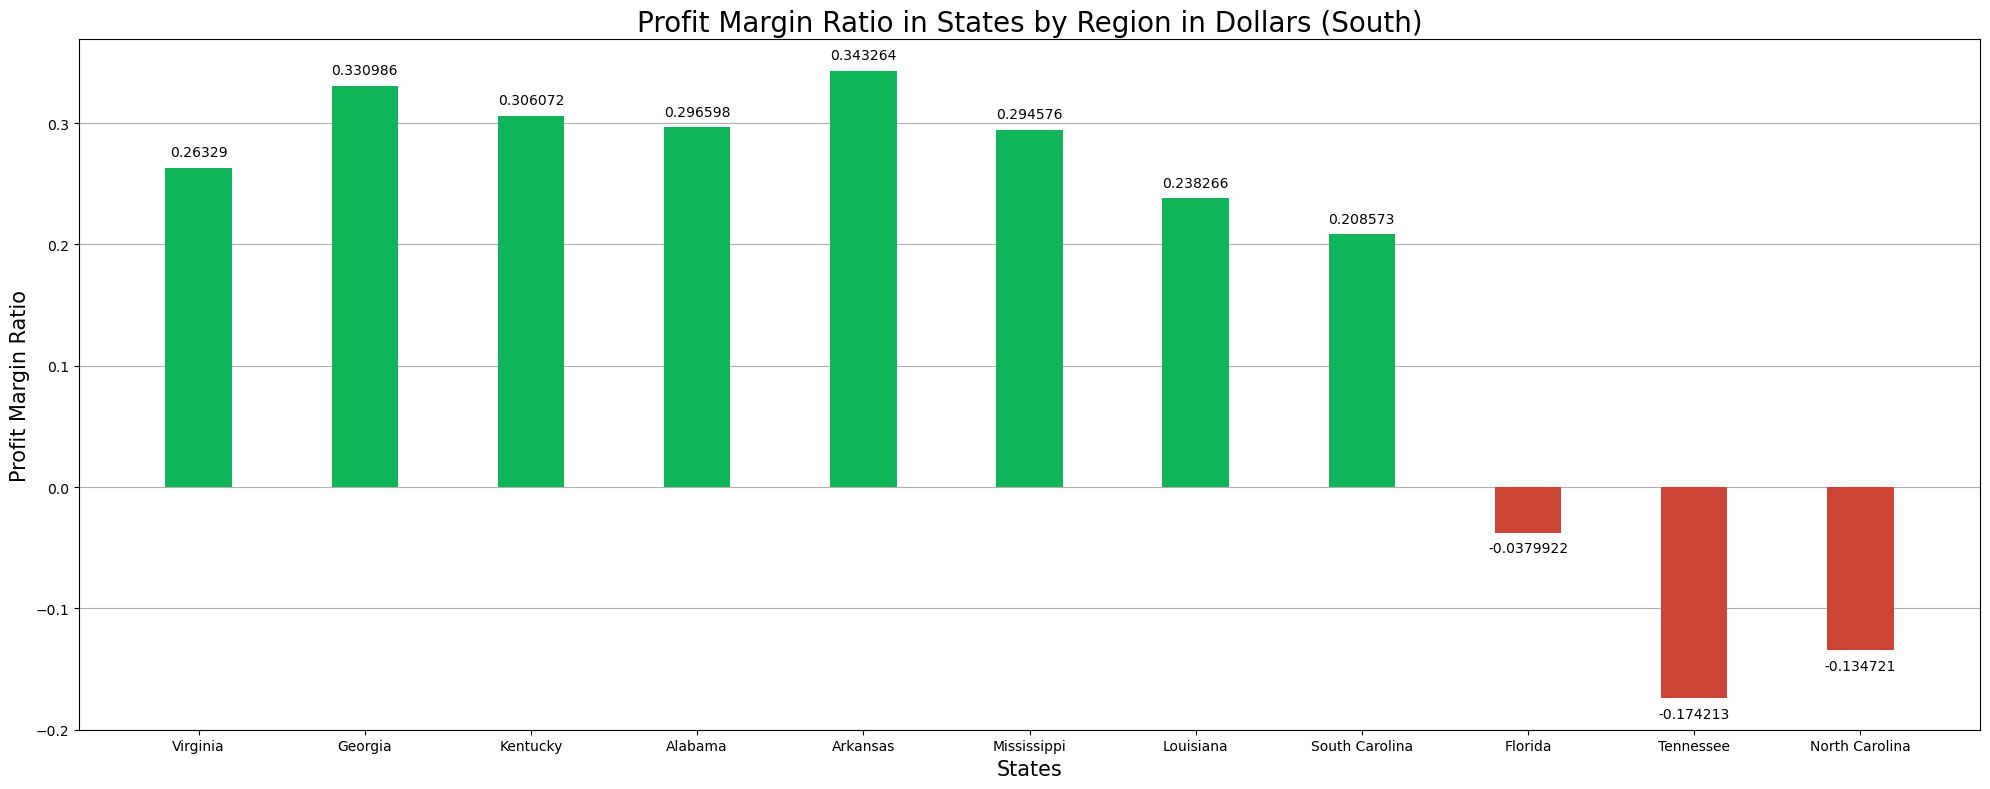

In [13]:
# Charts for Profit Margin Ratios of Each State by Region

def get_ratio(r):
    return r["Profit"]/r["Sales"]

for region_df in regions:
    region_data[region_df]["Profit Margin Ratio"] = region_data[region_df].apply(get_ratio,axis=1)
    clrs = ["#cc4435" if (v < 0) else "#10b55a" for v in region_data[region_df]["Profit Margin Ratio"]]
    x = list(region_data[region_df]["State"])
    x_labels = np.arange(len(x))
    y = np.array(region_data[region_df]["Profit Margin Ratio"])

    fig, ax = plt.subplots(figsize=(20,8),dpi=100)
    sales_bar = ax.bar(x_labels, y, 0.4, label = 'Profit Margin Ratio',color = clrs,zorder = 3)
    
    ax.set_ylabel("Profit Margin Ratio",fontsize = 15)
    ax.set_xlabel("States",fontsize = 15)
    ax.set_title("Profit Margin Ratio in States by Region in Dollars ({})".format(region_df),fontsize = 20)
    ax.set_xticks(x_labels)
    ax.set_xticklabels(x)
    ax.bar_label(sales_bar, padding=6)
    ax.grid(axis = 'y',zorder = 0)
    fig.tight_layout()
    plt.show()
    fig.savefig("profit_margin_charts/{}_profit_margin_chart.png".format(region_df.lower()))
    
    region_data[region_df].drop(columns=["Profit Margin Ratio"],inplace = True)


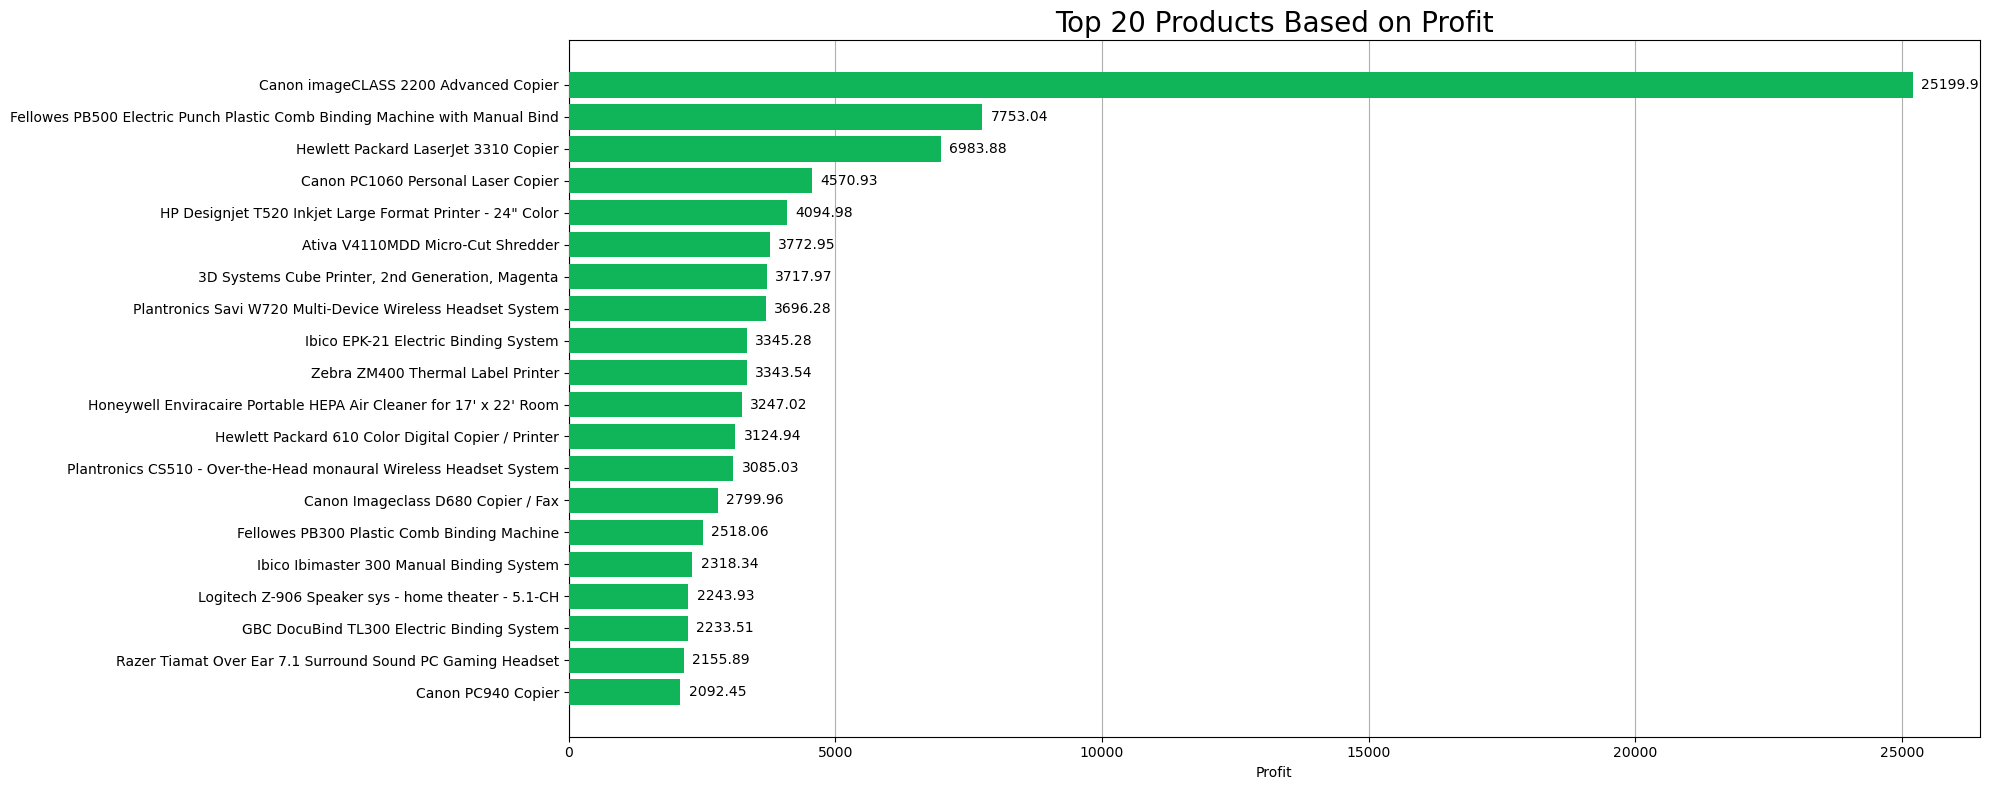

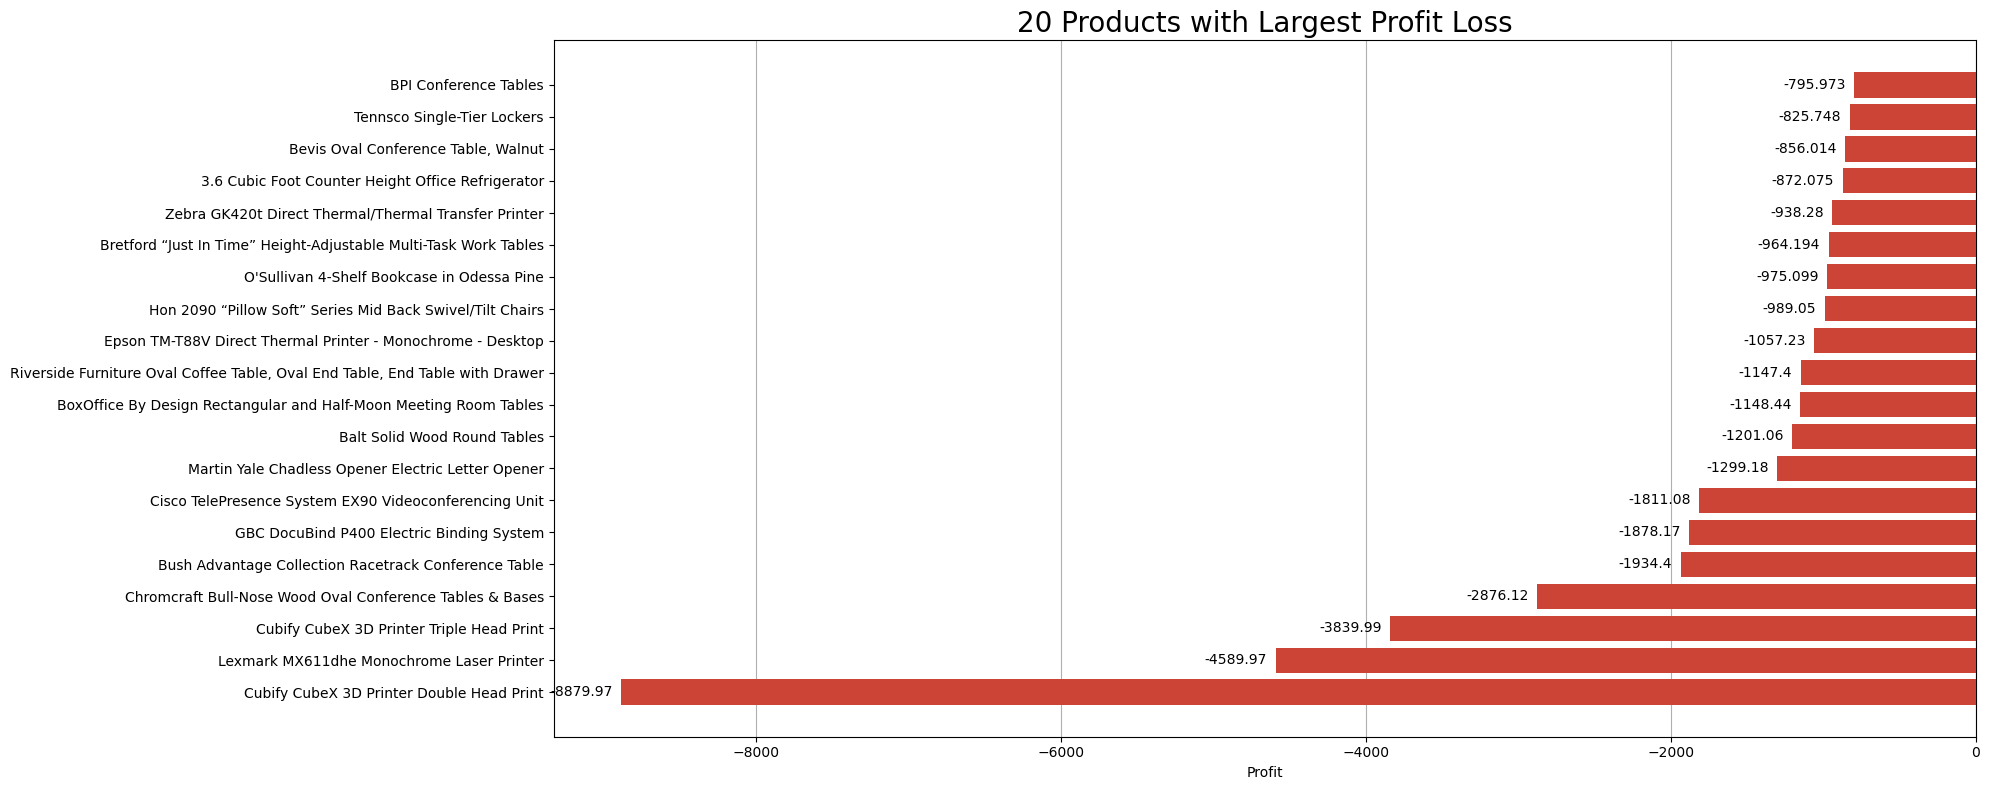

In [11]:
# Charts for Profits Based on Products

producttop = pd.DataFrame(dataset.groupby("Product Name").sum()).sort_values(by="Profit",ascending=False).reset_index().drop(columns = ["Quantity","Discount"]).head(20)
productbottom = pd.DataFrame(dataset.groupby("Product Name").sum()).sort_values(by="Profit",ascending=False).reset_index().drop(columns = ["Quantity","Discount"]).tail(20)

top_y_labels = list(producttop["Product Name"])
top_y = np.arange(len(top_y_labels))
top_x = np.array(producttop["Profit"])
fig, ax = plt.subplots(figsize=(20,8),dpi=100)
top_profit = ax.barh(top_y, top_x, align='center', color = "#10b55a",zorder = 3)
ax.set_yticks(top_y)
ax.set_yticklabels(top_y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Profit')
ax.bar_label(top_profit, padding=6)
ax.set_title('Top 20 Products Based on Profit',fontsize = 20)
ax.grid(axis = 'x',zorder = 0)
plt.tight_layout()
fig.savefig("product_profit_charts/top_products_chart.png")
plt.show()

bottom_y_labels = list(productbottom["Product Name"])
bottom_y = np.arange(len(bottom_y_labels))
bottom_x = np.array(productbottom["Profit"])
fig, ax = plt.subplots(figsize=(20,8),dpi=100)
bottom_profit = ax.barh(bottom_y, bottom_x, align='center', color = "#cc4435",zorder = 3)
ax.set_yticks(bottom_y)
ax.set_yticklabels(bottom_y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Profit')
ax.bar_label(bottom_profit, padding=6)
ax.set_title('20 Products with Largest Profit Loss',fontsize = 20)
ax.grid(axis = 'x',zorder = 0)
plt.tight_layout()
fig.savefig("product_profit_charts/bottom_products_chart.png")
plt.show()

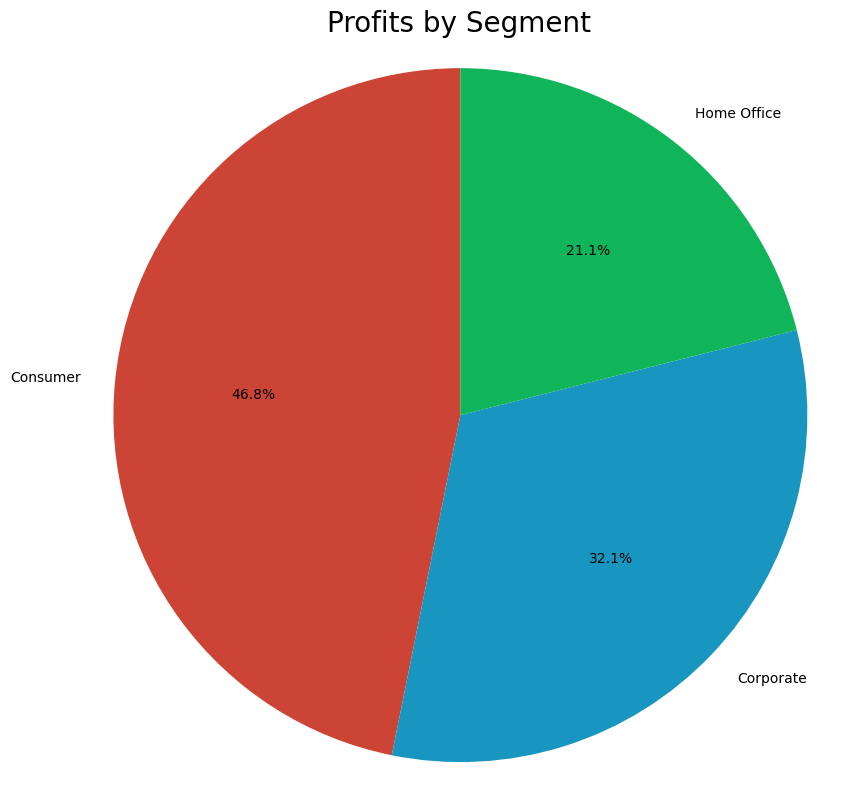

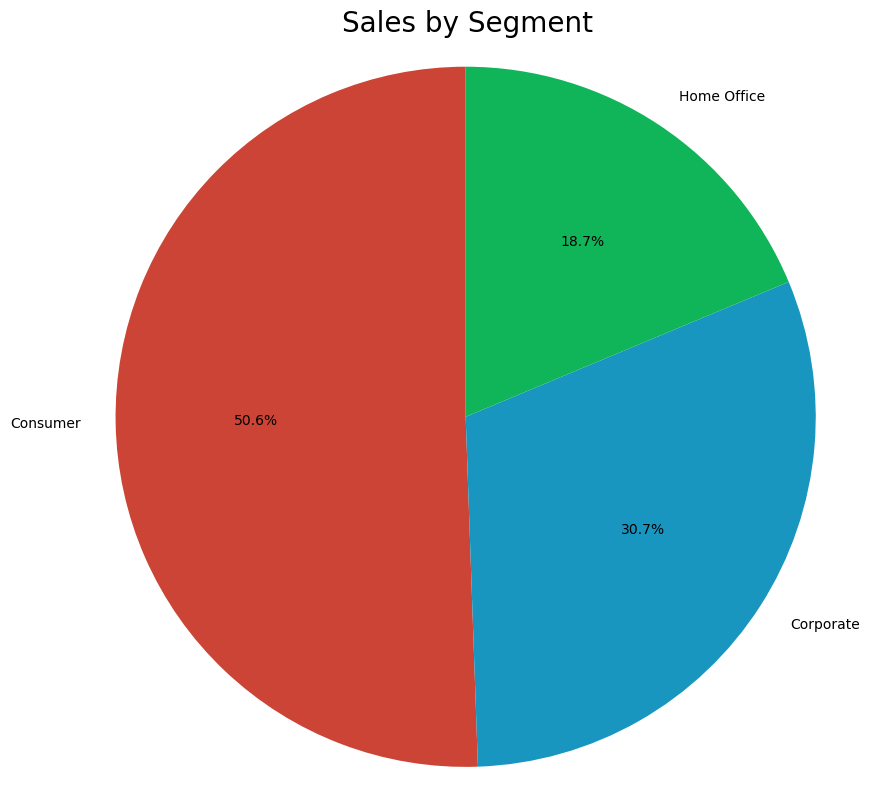

In [12]:
segment_profits = pd.DataFrame(dataset.groupby("Segment").sum()).sort_values(by="Profit",ascending=False).reset_index().drop(columns = ["Quantity","Discount"])
segment_profits

labels = list(segment_profits["Segment"])
profits = list(segment_profits["Profit"])
sales = list(segment_profits["Sales"])
colors = ["#cc4435","#1996bf","#10b55a"]

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
ax.pie(profits, labels=labels, autopct='%1.1f%%',startangle=90, colors=colors)
ax.axis('equal')
ax.set_title("Profits by Segment",fontsize = 20)
fig.savefig("segment_charts/profit_chart.png")
plt.show()

fig, ax = plt.subplots(figsize=(10,10),dpi=100)
ax.pie(sales, labels=labels, autopct='%1.1f%%',startangle=90, colors=colors)
ax.axis('equal')
ax.set_title("Sales by Segment",fontsize = 20)
fig.savefig("segment_charts/sales_chart.png")
plt.show()
